In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_percentage_error, accuracy_score, mean_squared_error, r2_score
import sklearn
from sklearn.utils.validation import check_symmetric
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

import hdbscan
from scipy.cluster import hierarchy
import scipy.spatial.distance as ssd

import os
import joblib

import warnings
warnings.filterwarnings('ignore')

import scipy

import shap
import lime
import learning
import pyAgrum
#from acv_explainers import ACXplainer

#from anchor import anchor_tabular

import json

from tqdm import tqdm, tqdm_notebook

from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss

from collections import Counter
import seaborn as sns

from itertools import filterfalse

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
def get_tree_features(cls, instance):
    tree = cls.tree_
    lvl = 0
    left_child = tree.children_left[lvl]
    right_child = tree.children_right[lvl]

    feats = []
    
    while left_child != sklearn.tree._tree.TREE_LEAF and right_child != sklearn.tree._tree.TREE_LEAF:
        feature = tree.feature[lvl]
        feats.append(feature)
        
        if instance[feature] < tree.threshold[lvl]:
            lvl = left_child
        else:
            lvl = right_child
            
        left_child = tree.children_left[lvl]
        right_child = tree.children_right[lvl]
            
            
    feat_pos = np.zeros(len(instance))
    n = len(feats)
    for i in feats:
        feat_pos[i]+=n
        n=n-1
    
    return feat_pos

In [3]:
def get_reg_features(cls):

    og_coef = cls.coef_
    if len(og_coef.shape) > 1:
        og_coef = og_coef[0]
    
    coef = [abs(val) for val in og_coef]
        
    return coef

In [4]:
def get_nb_features(cls, instance):
    pred = cls.predict(instance.reshape(1, -1))
    means = cls.theta_[pred][0]
    std = np.sqrt(cls.var_[pred])[0]
    
    alt = 1-pred
    alt_means = cls.theta_[alt][0]
    alt_std = np.sqrt(cls.var_[alt])[0]

    likelihoods = []
    
    for i in range(len(means)):
        lk = scipy.stats.norm(means[i], std[i]).logpdf(instance[i])
        alt_lk = scipy.stats.norm(alt_means[i], alt_std[i]).logpdf(instance[i])
        lkhood = lk-alt_lk
        likelihoods.append(lkhood)
        
    return np.abs(likelihoods)

In [5]:
def get_true_rankings(cls, instance, cls_method, X_train, feat_list):
    if cls_method == "decision_tree":
        feat_pos = get_tree_features(cls, instance)
        
    elif cls_method == "logit" or cls_method == "lin_reg":
        feat_pos = get_reg_features(cls)
        
    elif cls_method == "nb":
        feat_pos = get_nb_features(cls, instance)
        
    return feat_pos

In [6]:
def permute_instance(instance, i, perm_iter = 100, min_i = [0], max_i=[1], mean_i=[0], mode="permutation"):
            
    permutations = np.array([instance]*perm_iter).transpose()
    
    for j in range(len(i)):
        if mode=="baseline_max":
            n_val = [max_i[j]]*perm_iter
        elif mode=="baseline" or mode=="baseline_mean":
            n_val = [mean_i[j]]*perm_iter
        elif mode=="baseline_min":
            n_val = [min_i[j]]*perm_iter
        elif mode=="baseline_0":
            n_val = [0]*perm_iter
        else:
            n_val = np.random.uniform(min_i[j], max_i[j], perm_iter)


        permutations[i[j]] = n_val
    
    permutations = permutations.transpose()

    return permutations

In [7]:
def cycle_values(instance, i, perm_iter = 100, min_i = [0], max_i=[1], mean_i=[0], unique_values=[[0,1]], mode="permutation"):

    permutations = np.array([instance]*perm_iter).transpose()

    for j in range(len(i)):
        if mode=="baseline_max":
            n_val = [max_i[j]]*perm_iter
        elif mode=="baseline" or mode=="baseline_mean":
            n_val = [mean_i[j]]*perm_iter
        elif mode=="baseline_min":
            n_val = [min_i[j]]*perm_iter
        elif mode=="baseline_0":
            n_val = [0]*perm_iter
        else:
            n_val = np.random.choice(unique_values[j], perm_iter)

        permutations[i[j]] = n_val
        
    permutations = permutations.transpose()

    return permutations

In [8]:
def permute_multiple(instance, i, columns, col_dict, perm_iter=100, min_i = [0], max_i=[1], mean_i=[0],unique_values=[[0,1]], mode="permutation"):
    
    cats = []
    nums = []
    
    if col_dict["discrete"]!=None:
        cats = [int(col) for col in i if columns[col] in col_dict["discrete"]]
    if col_dict["continuous"]!=None:
        nums = [int(col) for col in i if columns[col] in col_dict["continuous"]]
    
    cat_permutations = False
    num_permutations = False
    
    if len(cats)>0:
        mins = min_i[columns[cats]].values
        maxes = max_i[columns[cats]].values
        means = mean_i[columns[cats]].values
        uniques = unique_values[columns[cats]].values
        cat_permutations = cycle_values(instance, cats, perm_iter, mins, maxes, 
                                  means, uniques, mode) 
    if len(nums)>0:
        mins = min_i[columns[nums]].values
        maxes = max_i[columns[nums]].values
        means = mean_i[columns[nums]].values
        num_permutations = permute_instance(instance, nums, perm_iter, mins, maxes, 
                                  means, mode)
        
    permutations = np.array([instance]*perm_iter).transpose()
    if type(cat_permutations)!=bool:
        cat_permutations = cat_permutations.transpose()
        for j in cats:
            permutations[j] = cat_permutations[j]
            
    if type(num_permutations)!=bool:
        num_permutations = num_permutations.transpose()
        for j in nums:
            permutations[j] = num_permutations[j]
#     if  len(cats)>0:
#         print("categorical:", permutations[cats])
#     if len(nums)>0:
#         print("numeric", permutations[nums])
#     print("all", permutations[i])        
    permutations = permutations.transpose()
    
    return permutations

In [9]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = scipy.stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [38]:
pd.crosstab(full_enc.iloc[:, 9], full_enc.iloc[:, 8]).sum().sum()

7214

In [10]:
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

In [11]:
# path to project folder
# please change to your own
PATH = os.getcwd()

dataset = "compas"
cls_method = "nb"

classification = True
# xai_method = "SHAP"

modes = ["permutation", "baseline_min", "baseline_mean", "baseline_max", "baseline_0"]

random_state = 22
exp_iter = 10
perm_iter = 1000

save_to = "%s/%s/" % (PATH, dataset)
dataset_folder = "%s/datasets/" % (save_to)
final_folder = "%s/%s/" % (save_to, cls_method)

#Get datasets
X_train = pd.read_csv(dataset_folder+dataset+"_Xtrain.csv", index_col=False, sep = ";")
y_train = pd.read_csv(dataset_folder+dataset+"_Ytrain.csv", index_col=False, sep = ";")
test_x = pd.read_csv(final_folder+"test_sample.csv", index_col=False, sep = ";")
results = pd.read_csv(os.path.join(final_folder,"results.csv"), index_col=False, sep = ";")
actual = results["Actual"].values

with open(dataset_folder+"col_dict.json", "r") as f:
    col_dict = json.load(f)
f.close()

feat_list = [each.replace(' ','_') for each in X_train.columns]

cls = joblib.load(save_to+cls_method+"/cls.joblib")
scaler = joblib.load(save_to+"/scaler.joblib")

In [12]:
#If there are discrete columns, get the original dataset, not the one-hot encoded version
if col_dict["discrete"]!=None:
    if dataset == "compas":
        data = pd.read_csv(dataset_folder+"compas-scores-two-years.csv")

        keep_cols = ['age', 'age_cat', 'sex', 'race',  'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out',
                       'c_charge_degree', 'is_recid', 'is_violent_recid', 'two_year_recid', 'decile_score', 'score_text']

        df = data[keep_cols]

        target_col = 'class'

        df['days_b_screening_arrest'] = np.abs(df['days_b_screening_arrest'])

        df['c_jail_out'] = pd.to_datetime(df['c_jail_out'])
        df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
        df['length_of_stay'] = (df['c_jail_out'] - df['c_jail_in']).dt.days
        df['length_of_stay'] = np.abs(df['length_of_stay'])

        df['length_of_stay'].fillna(df['length_of_stay'].value_counts().index[0], inplace=True)
        df['days_b_screening_arrest'].fillna(df['days_b_screening_arrest'].value_counts().index[0], inplace=True)

        df['length_of_stay'] = df['length_of_stay'].astype(int)
        df['days_b_screening_arrest'] = df['days_b_screening_arrest'].astype(int)

        def get_class(x):
            if x < 7:
                return 'Medium-Low'
            else:
                return 'High'

        df['class'] = df['decile_score'].apply(get_class)

        del df['c_jail_in']
        del df['c_jail_out']
        del df['decile_score']
        del df['score_text']

        target_name = "class"

        feature_names = [col for col in df.columns if col != target_col]

        #df = remove_missing_values(df)

        possible_outcomes = list(df[target_col].unique())
        #print("Possible outcomes:", possible_outcomes)

        #numerical_cols, categorical_cols, columns_type = get_columns_type(df)


        #for column in data.columns:
        #    data[column].replace(' ?', None, inplace=True)
        pro_data = df.dropna()

        other_cat_cols = ['is_recid', 'is_violent_recid', 'two_year_recid']
        
    elif dataset == "income":
        pro_data = pd.read_csv(dataset_folder+"adult.csv", index_col = False)
        target_col = 'income-class'
        for column in pro_data.columns:
            pro_data[column].replace(' ?', None, inplace=True)
        pro_data = pro_data.drop('fnlwgt', axis=1)
        other_cat_cols = []
        
    elif dataset == "mushroom":
        df = pd.read_csv(dataset_folder+"mushroom_unpro.csv")
        target_col = 'target'
        pro_data = df.dropna()
        other_cat_cols = []
        
    elif dataset == "nursery":
        df = pd.read_csv(dataset_folder+"nursery_unpro.csv")
        other_cat_cols = []
        target_col = 'class'
        feature_names = [col for col in df.columns if col != target_col]
        possible_outcomes = list(df[target_col].unique())
#         print("Possible outcomes:", possible_outcomes)
#         print(df[target_col].value_counts())

        def binarise_targets(x):
            if x == "not_recom":
                return "0_declined"
            else:
                return "1_approved"

        df[target_col] = df[target_col].apply(binarise_targets)

        pro_data = df.dropna()

    else:
        print("cannot find dataset")
        
    non_num_cols = [column for column in pro_data.drop([target_col], axis = 1).columns if pro_data[column].dtypes == "O"]
    num_cols = [column for column in pro_data.drop([target_col], axis = 1).columns if column not in non_num_cols]
    # if other_cat_cols != None:
    #     num_cols.extend(other_cat_cols)

    num_data = pro_data[num_cols]
    cat_data = pro_data[non_num_cols]
    
    if other_cat_cols != None:
        num_cols = list(filterfalse(other_cat_cols.__contains__, num_cols))
        non_num_cols = non_num_cols + other_cat_cols

    onehot = OneHotEncoder(sparse=True, handle_unknown='ignore').fit(cat_data)

    orig_cols = np.arange(len(num_data.columns)).reshape(-1, 1).tolist()

    for col in cat_data.columns:
        new_cols = [i for i in range(len(X_train.columns)) if col in X_train.columns[i]]
        orig_cols.append(new_cols)

    orig_col_names = []
    orig_col_names.extend(num_data.columns)
    orig_col_names.extend(cat_data.columns)
else:
    num_data = X_train.copy()
    orig_cols = np.arange(X_train.shape[1]).reshape(-1, 1)
    orig_col_names= X_train.columns.tolist()
    cat_data = 0
    pro_data = X_train.copy()
    
    num_cols = X_train.columns.tolist()
    non_num_cols = []

In [13]:
min_X = np.min(X_train)
max_X = np.max(X_train)
mean_X = np.mean(X_train, axis=0)
unique_values = pd.Series({col: X_train[col].unique() for col in X_train.columns})


In [14]:
if type(cat_data)!=int:
    min_num = np.min(X_train[num_data.columns])
    max_num = np.max(X_train[num_data.columns])
    mean_num = np.mean(X_train[num_data.columns], axis=0)
    num_orig = pd.Series({col: num_data[col].unique() for col in num_data.columns})
    
    min_cat = pd.Series({col: 0 for col in cat_data.columns})
    max_cat = pd.Series({col: 1 for col in cat_data.columns})
    mean_cat = pd.Series({col: 0.5 for col in cat_data.columns})
    cat_orig = pd.Series({col: cat_data[col].unique() for col in cat_data.columns})

    min_orig = min_num.append(min_cat)
    max_orig = max_num.append(max_cat)
    mean_orig = mean_num.append(mean_cat)
    unique_orig = num_orig.append(cat_orig)
    
else:
    min_orig = min_X.copy()
    max_orig = max_X.copy()
    mean_orig = mean_X.copy()
    unique_orig = unique_values.copy()

In [15]:
if non_num_cols!=[]:
    ordinal = OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = -1)
    cat_enc = pd.DataFrame(ordinal.fit_transform(cat_data), columns = cat_data.columns)
    full_enc = pd.concat([num_data, cat_enc], axis=1)
else:
    full_enc = pro_data.copy()

<AxesSubplot:>

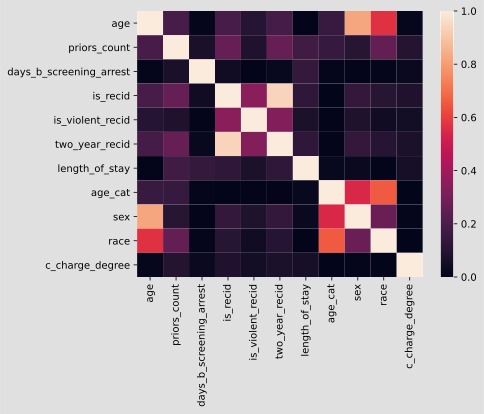

In [16]:
import matplotlib.pyplot as plt

corr_mat = np.zeros((full_enc.shape[1],full_enc.shape[1]))
for i in range(full_enc.shape[1]):
    for j in range(full_enc.shape[1]):
        if num_cols!=[]:
            if full_enc.columns[i] in num_cols and full_enc.columns[j] in num_cols:
                corr_mat[i][j] = abs(scipy.stats.pearsonr(X_train.iloc[:, i], X_train.iloc[:, j]).statistic)
            elif full_enc.columns[i] in non_num_cols and full_enc.columns[j] in non_num_cols:
                corr_mat[i][j] = cramers_v(X_train.iloc[:, i], X_train.iloc[:, j])
            elif full_enc.columns[i] in num_cols and full_enc.columns[j] in non_num_cols:
                corr_mat[i][j] = correlation_ratio(X_train.iloc[:, j], X_train.iloc[:, i])
            elif full_enc.columns[i] in non_num_cols and full_enc.columns[j] in num_cols:
                corr_mat[i][j] = correlation_ratio(X_train.iloc[:, i], X_train.iloc[:, j])
                
sns.heatmap(corr_mat, yticklabels=orig_col_names, xticklabels = orig_col_names)
# plt.xticks(orig_col_names)
# plt.yticks(orig_col_names)

In [17]:
# corr = full_enc.corr().fillna(0)
# np.fill_diagonal(corr.values, 1)
# # a = np.where(np.triu(corr, k=1)==0, np.nan,corr)
# # corr = np.where(np.isnan(a), a.T, a)
# distances = 1-corr.abs().values
# sns.heatmap(corr)

In [18]:
# %matplotlib inline
# sns.heatmap(corr.abs())
# plt.show()

In [19]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, metric="manhattan", cluster_selection_method="leaf").fit(corr_mat)
clusters = clusterer.labels_
clusters

array([ 0, -1,  2,  1,  1,  1,  2,  0,  0,  0,  2], dtype=int64)

-1


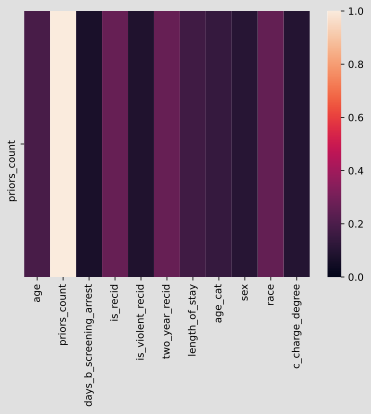

0


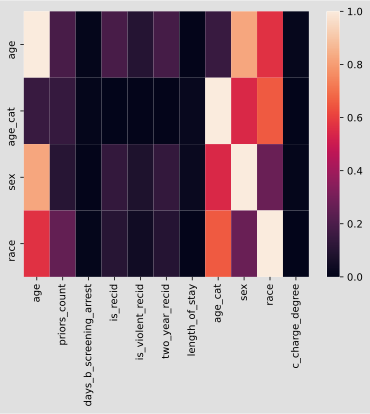

1


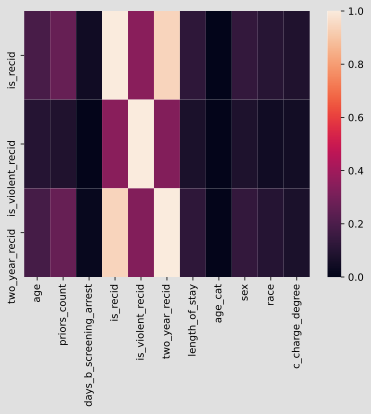

2


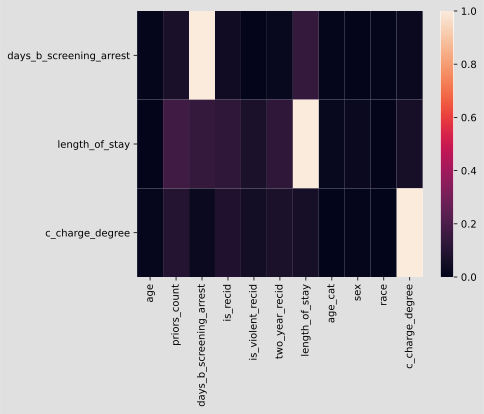

In [20]:
import matplotlib.pyplot as plt
for each in np.unique(clusters):
    print(each)
    ind = np.where(clusters==each)
    rel_cols = full_enc.columns[ind]
    #sns.heatmap(full_enc[rel_cols].corr().abs(),vmin=0, vmax=1)
    sns.heatmap(corr_mat[ind], yticklabels=rel_cols, xticklabels = orig_col_names, vmin=0,vmax=1)
    plt.show()


In [22]:
# import matplotlib.pyplot as plt
# for each in np.unique(clusters):
#     ind = np.where(clusters==each)
#     rel_cols = X_train.columns[ind]
#     sns.heatmap(X_train[rel_cols].corr().abs(),vmin=0, vmax=1)
#     plt.show()

corr_cols = []

for each in np.unique(clusters):
    ind = np.where(clusters==each)[0]
    if each == -1:
        corr_cols.extend(np.array(ind).reshape(-1,1))
    else:
        corr_cols.append(ind)
    
#corr_cols

In [23]:
#permute individual features
for mode in modes:
    print(mode)
    ktb_list = []
    true_v_mape = []
    true_v_rmse = []
    true_v_r2 = []

    for i in tqdm_notebook(range(len(test_x.values))):
        instance = test_x.values[i]

        tr = get_true_rankings(cls, instance, cls_method, X_train, feat_list)

        if classification:
            pred = cls.predict(instance.reshape(1, -1))
            proba = cls.predict_proba(instance.reshape(1, -1)).reshape(2)[pred]
            p1_list = list(proba)*perm_iter

        perm_mape = np.zeros(len(instance))
        perm_rmse = np.zeros(len(instance))
        perm_r2 = np.zeros(len(instance))

        for j in range(len(instance)):
            if col_dict["continuous"] != None:
                if X_train.columns[j] in col_dict["continuous"]:
                    permutations = permute_instance(instance, [j], perm_iter, [min_X[j]], [max_X[j]], [mean_X[j]], mode)
                else:
                    permutations = cycle_values(instance, [j], perm_iter, [min_X[j]], [max_X[j]], [mean_X[j]], [unique_values[X_train.columns[j]]], mode)
            else:
                permutations = cycle_values(instance, [j], perm_iter, [min_X[j]], [max_X[j]], [mean_X[j]], [unique_values[X_train.columns[j]]], mode)

            if classification:
                p2_list = cls.predict_proba(permutations).transpose()[pred].reshape(perm_iter)
                perm_mape[j] = mean_absolute_percentage_error(p1_list, p2_list)
                perm_rmse[j] = mean_squared_error(p1_list, p2_list, squared=False)
                perm_r2[j] = r2_score(p1_list, p2_list)

        #print("Final MAPE for all features:", perm_mape)
        mape_corr = scipy.stats.kendalltau(tr, perm_mape, variant="b")[0]
        rmse_corr = scipy.stats.kendalltau(tr, perm_rmse, variant="b")[0]
        r2_corr = scipy.stats.kendalltau(tr, perm_r2, variant="b")[0]

        true_v_mape.append(mape_corr)
        true_v_rmse.append(rmse_corr)
        true_v_r2.append(r2_corr)
        
    print("MAPE", np.nanmean(true_v_mape))
    print("RMSE", np.nanmean(true_v_rmse))
    print("R-Squared", np.nanmean(true_v_r2))

    results["MAPE Correctness"] = true_v_mape
    results["RMSE Correctness"] = true_v_rmse
    results["R2 Correctness"] = true_v_r2
    results.to_csv(os.path.join(save_to, cls_method, mode+"_results.csv"), index = False, sep = ";")


permutation


  0%|          | 0/100 [00:00<?, ?it/s]

MAPE 0.2874166888806115
RMSE 0.29332564461432936
R-Squared -0.2940333417004025
baseline_min


  0%|          | 0/100 [00:00<?, ?it/s]

MAPE 0.12080976911681937
RMSE 0.12080976911681937
R-Squared -0.10999359948907665
baseline_mean


  0%|          | 0/100 [00:00<?, ?it/s]

MAPE 0.45048728503558527
RMSE 0.45048728503558527
R-Squared -0.4485677024609272
baseline_max


  0%|          | 0/100 [00:00<?, ?it/s]

MAPE 0.07982424685272048
RMSE 0.07942900458766332
R-Squared -0.06820749654319624
baseline_0


  0%|          | 0/100 [00:00<?, ?it/s]

MAPE 0.12101619115948135
RMSE 0.12101619115948135
R-Squared -0.1102000215317386


In [24]:
#permute original features
for mode in modes:
        print(mode)
    #if col_dict["discrete"]!=None:
        ktb_list = []
        true_v_mape = []
        true_v_rmse = []
        true_v_r2 = []
        
        if col_dict["discrete"]!=None:
            orig_cat = onehot.inverse_transform(test_x.values[:, len(num_data.columns):])
            orig_num = test_x.values[:, :len(num_data.columns)]
            orig_test = np.hstack((orig_num, orig_cat))
        else:
            orig_test = test_x.values.copy()
        
        for i in tqdm_notebook(range(len(test_x.values))):
            instance = test_x.values[i]
            og_instance = orig_test[i]

            tr = get_true_rankings(cls, instance, cls_method, X_train, feat_list)
            cr = []
            for cluster in orig_cols:
                ranks = np.array(tr)[cluster]
                cr.append(np.sum(abs(ranks)))

            pred = cls.predict(instance.reshape(1, -1))
            proba = cls.predict_proba(instance.reshape(1, -1)).reshape(2)[pred]
            p1_list = list(proba)*perm_iter

            perm_mape = np.zeros(len(orig_cols))
            perm_rmse = np.zeros(len(orig_cols))
            perm_r2 = np.zeros(len(orig_cols))

            for j in range(len(orig_cols)):
                cols = orig_cols[j]
                if col_dict["continuous"] != None:
                    if orig_col_names[j] in col_dict["continuous"]:
                        permutations = permute_instance(og_instance, [j], perm_iter, [min_X[cols]], [max_X[cols]], [mean_X[cols]], mode)
                    else:
                        permutations = cycle_values(og_instance, [j], perm_iter, [0], [1], [0.5], [unique_orig[orig_col_names[j]]], mode)
                else:
                    permutations = cycle_values(og_instance, [j], perm_iter, [0], [1], [0.5], [unique_orig[orig_col_names[j]]], mode)
                    
                if col_dict["discrete"]!=None:
                    num_perm = permutations[:, :len(num_data.columns)]
                    cat_perm = permutations[:, len(num_data.columns):]

                    cat_perm = onehot.transform(cat_perm).toarray()

                    permutations = np.hstack((num_perm, cat_perm))
 
                p2_list = cls.predict_proba(permutations).transpose()[pred].reshape(perm_iter)
                perm_mape[j] = mean_absolute_percentage_error(p1_list, p2_list)
                perm_rmse[j] = mean_squared_error(p1_list, p2_list, squared=False)
                perm_r2[j] = r2_score(p1_list, p2_list)

            #print("Final MAPE for all features:", perm_mape)
            mape_corr = scipy.stats.kendalltau(cr, perm_mape, variant="b")[0]
            rmse_corr = scipy.stats.kendalltau(cr, perm_rmse, variant="b")[0]
            r2_corr = scipy.stats.kendalltau(cr, perm_r2, variant="b")[0]

            true_v_mape.append(mape_corr)
            true_v_rmse.append(rmse_corr)
            true_v_r2.append(r2_corr)
            
        print("MAPE", np.nanmean(true_v_mape))
        print("RMSE", np.nanmean(true_v_rmse))
        print("R-Squared", np.nanmean(true_v_r2))

        #results[xai_method+"_KT-B"] = ktb_list
        results["MAPE Correctness"] = true_v_mape
        results["RMSE Correctness"] = true_v_rmse
        results["R2 Correctness"] = true_v_r2
        results.to_csv(os.path.join(save_to, cls_method, mode+"__orig_results.csv"), index = False, sep = ";")
        
#     else:
#         results["MAPE Correctness"] = [np.nan]*results.shape[0]
#         results["RMSE Correctness"] = [np.nan]*results.shape[0]
#         results["R2 Correctness"] = [np.nan]*results.shape[0]
#         results.to_csv(os.path.join(save_to, cls_method, mode+"__orig_results.csv"), index = False, sep = ";") 

permutation


  0%|          | 0/100 [00:00<?, ?it/s]

MAPE 0.13997224527767116
RMSE 0.1443358816413075
R-Squared -0.15473729977070436
baseline_min


  0%|          | 0/100 [00:00<?, ?it/s]

MAPE 0.33724731364900656
RMSE 0.33724731364900656
R-Squared -0.3171646671969991
baseline_mean


  0%|          | 0/100 [00:00<?, ?it/s]

MAPE 0.37892853215665745
RMSE 0.37892853215665745
R-Squared -0.378534489020995
baseline_max


  0%|          | 0/100 [00:00<?, ?it/s]

MAPE -0.16813227597162736
RMSE -0.1689462101010086
R-Squared 0.1614326763143678
baseline_0


  0%|          | 0/100 [00:00<?, ?it/s]

MAPE 0.3382151801556723
RMSE 0.3382151801556723
R-Squared -0.3181522860813518


In [25]:
#permute correlated features
for mode in modes:
        print(mode)
    #if col_dict["discrete"]!=None:
        ktb_list = []
        true_v_mape = []
        true_v_rmse = []
        true_v_r2 = []
        
        if col_dict["discrete"]!=None:
            orig_cat = onehot.inverse_transform(test_x.values[:, len(num_data.columns):])
            orig_num = test_x.values[:, :len(num_data.columns)]
            orig_test = np.hstack((orig_num, orig_cat))
        else:
            orig_test = test_x.values.copy()
        
        for i in tqdm_notebook(range(len(test_x.values))):
            instance = test_x.values[i]
            og_instance = orig_test[i]

            cols_mapped = []
            for each in corr_cols:
                cluster = []
                for col in each:
                    cluster.extend(orig_cols[col])
                cols_mapped.append(cluster)
            #print(cols_mapped)

            instance = test_x.values[0]
            tr = get_true_rankings(cls, instance, cls_method, X_train, feat_list)
            cr = []
            for cluster in cols_mapped:
                ranks = np.array(tr)[cluster]
                cr.append(np.sum(abs(ranks)))

            pred = cls.predict(instance.reshape(1, -1))
            proba = cls.predict_proba(instance.reshape(1, -1)).reshape(2)[pred]
            p1_list = list(proba)*perm_iter

            perm_mape = np.zeros(len(corr_cols))
            perm_rmse = np.zeros(len(corr_cols))
            perm_r2 = np.zeros(len(corr_cols))

            for j in range(len(corr_cols)):
                cols = corr_cols[j]
                orig_col_dict = {"continuous": num_cols, "discrete": non_num_cols}
                
                mins = min_orig[np.array(orig_col_names)[corr_cols[j]]]
                means = mean_orig[np.array(orig_col_names)[corr_cols[j]]]
                maxes = max_orig[np.array(orig_col_names)[corr_cols[j]]]
                uniques = unique_orig[np.array(orig_col_names)[corr_cols[j]]]
                                
                permutations = permute_multiple(og_instance, cols, np.array(orig_col_names), orig_col_dict, perm_iter, 
                                                mins, maxes, means, uniques, mode)                   
                
                if col_dict["discrete"]!=None:
                    num_perm = permutations[:, :orig_num.shape[1]]
                    cat_perm = permutations[:, orig_num.shape[1]:]

                    cat_perm = onehot.transform(cat_perm).toarray()

                    permutations = np.hstack((num_perm, cat_perm))
 
                p2_list = cls.predict_proba(permutations).transpose()[pred].reshape(perm_iter)
                perm_mape[j] = mean_absolute_percentage_error(p1_list, p2_list)
                perm_rmse[j] = mean_squared_error(p1_list, p2_list, squared=False)
                perm_r2[j] = r2_score(p1_list, p2_list)

            #print("Final MAPE for all features:", perm_mape)
            mape_corr = scipy.stats.kendalltau(cr, perm_mape, variant="b")[0]
            rmse_corr = scipy.stats.kendalltau(cr, perm_rmse, variant="b")[0]
            r2_corr = scipy.stats.kendalltau(cr, perm_r2, variant="b")[0]
            
            #print(mape_corr,rmse_corr,r2_corr)

            true_v_mape.append(mape_corr)
            true_v_rmse.append(rmse_corr)
            true_v_r2.append(r2_corr)
            
        print("MAPE", np.nanmean(true_v_mape))
        print("RMSE", np.nanmean(true_v_rmse))
        print("R-Squared", np.nanmean(true_v_r2))

        #results[xai_method+"_KT-B"] = ktb_list
        results["MAPE Correctness"] = true_v_mape
        results["RMSE Correctness"] = true_v_rmse
        results["R2 Correctness"] = true_v_r2
        results.to_csv(os.path.join(save_to, cls_method, mode+"__corr_results.csv"), index = False, sep = ";")
        
#     else:
#         results["MAPE Correctness"] = [np.nan]*results.shape[0]
#         results["RMSE Correctness"] = [np.nan]*results.shape[0]
#         results["R2 Correctness"] = [np.nan]*results.shape[0]
#         results.to_csv(os.path.join(save_to, cls_method, mode+"__corr_results.csv"), index = False, sep = ";") 

permutation


  0%|          | 0/100 [00:00<?, ?it/s]

MAPE 0.5203181503833679
RMSE 0.5336514837167011
R-Squared -0.5336514837167011
baseline_min


  0%|          | 0/100 [00:00<?, ?it/s]

MAPE -0.07501342633197822
RMSE -0.07501342633197822
R-Squared 0.07501342633197822
baseline_mean


  0%|          | 0/100 [00:00<?, ?it/s]

MAPE -0.05414213562373098
RMSE -0.05414213562373098
R-Squared 0.05414213562373098
baseline_max


  0%|          | 0/100 [00:00<?, ?it/s]

MAPE 0.2918645669183227
RMSE 0.2918645669183227
R-Squared -0.2918645669183227
baseline_0


  0%|          | 0/100 [00:00<?, ?it/s]

MAPE -0.07501342633197822
RMSE -0.07501342633197822
R-Squared 0.07501342633197822


In [26]:
cols_mapped

[[1], [0, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], [3, 4, 5], [2, 6, 18, 19]]

In [27]:
# for mode in modes:
#     if len(corr_cols) > 1:
#         ktb_list = []
#         true_v_mape = []
#         true_v_rmse = []
#         true_v_r2 = []

#         for i in tqdm_notebook(range(len(test_x))):
#             instance = test_x.values[i]

#             tr = get_true_rankings(cls, instance, cls_method, X_train, feat_list)
#             cr = []
#             for cluster in corr_cols:
#                 ranks = np.array(tr)[cluster]
#                 cr.append(np.sum(ranks))

#             pred = cls.predict(instance.reshape(1, -1))
#             proba = cls.predict_proba(instance.reshape(1, -1)).reshape(2)[pred]
#             p1_list = list(proba)*perm_iter

#             perm_mape = np.zeros(len(corr_cols))
#             perm_rmse = np.zeros(len(corr_cols))
#             perm_r2 = np.zeros(len(corr_cols))

#             for j in range(len(corr_cols)):
#                 mins = min_X[X_train.columns[corr_cols[j]]]
#                 means = mean_X[X_train.columns[corr_cols[j]]]
#                 maxes = max_X[X_train.columns[corr_cols[j]]]
#                 uniques = unique_values[X_train.columns[corr_cols[j]]]
                
#                 permutations = permute_multiple(instance, corr_cols[j], X_train.columns, col_dict, perm_iter, 
#                                                 mins, maxes, means, uniques, mode)
 
#                 p2_list = cls.predict_proba(permutations).transpose()[pred].reshape(perm_iter)
#                 perm_mape[j] = mean_absolute_percentage_error(p1_list, p2_list)
#                 perm_rmse[j] = mean_squared_error(p1_list, p2_list, squared=False)
#                 perm_r2[j] = r2_score(p1_list, p2_list)

#             #print("Final MAPE for all features:", perm_mape)
#             mape_corr = scipy.stats.kendalltau(cr, perm_mape, variant="b")[0]
#             rmse_corr = scipy.stats.kendalltau(cr, perm_rmse, variant="b")[0]
#             r2_corr = scipy.stats.kendalltau(cr, perm_r2, variant="b")[0]

#             true_v_mape.append(mape_corr)
#             true_v_rmse.append(rmse_corr)
#             true_v_r2.append(r2_corr)
            
#         print("MAPE", np.nanmean(true_v_mape))
#         print("RMSE", np.nanmean(true_v_rmse))
#         print("R-Squared", np.nanmean(true_v_r2))

#         #results[xai_method+"_KT-B"] = ktb_list
#         results["MAPE Correctness"] = true_v_mape
#         results["RMSE Correctness"] = true_v_rmse
#         results["R2 Correctness"] = true_v_r2
#         results.to_csv(os.path.join(save_to, cls_method, mode+"__corr_results.csv"), index = False, sep = ";")
    
#     else:
#         results["MAPE Correctness"] = [np.nan]*results.shape[0]
#         results["RMSE Correctness"] = [np.nan]*results.shape[0]
#         results["R2 Correctness"] = [np.nan]*results.shape[0]
#         results.to_csv(os.path.join(save_to, cls_method, mode+"__corr_results.csv"), index = False, sep = ";")


In [28]:
results.isna().sum()

Actual                              0
Prediction                          0
Prediction Probability              0
SHAP Subset Stability               0
SHAP Weight Stability               0
SHAP Adjusted Weight Stability      0
LIME Subset Stability               0
LIME Weight Stability               0
LIME Adjusted Weight Stability      0
ACV Subset Stability               24
ACV Weight Stability                0
ACV Adjusted Weight Stability       0
LINDA Subset Stability             45
LINDA Weight Stability              0
LINDA Adjusted Weight Stability     0
MAPE Correctness                    0
RMSE Correctness                    0
R2 Correctness                      0
dtype: int64

In [29]:
results.shape

(100, 18)

In [30]:
len(perm_mape)

4